# Цели ```04_core_analysis.ipynb```
- Выявить ключевые факторы, влияющие на популярность статьи.
- Построить простые гипотезы и модели, объясняющие успех.

In [25]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from scipy.stats import ttest_ind
import ast


##  1. Создание бинарной метки is_popular
В этом блоке мы создаём целевую переменную для анализа — бинарную метку популярности.
Статьи делятся на две группы: "популярные" (топ-10% по просмотрам) и все остальные.
Это необходимо для последующих сравнений и построения модели классификации.



In [26]:
# Загрузка данных
path = Path.cwd().parent / "data" / "processed" / "clean_articles.csv"
df = pd.read_csv(path)


In [27]:
# Определение метки популярности
threshold = df["views"].quantile(0.90)
df["is_popular"] = (df["views"] >= threshold).astype(int)


In [41]:
# Вывод распределения метки
popular_count = df["is_popular"].sum()
nonpopular_count = len(df) - popular_count

print("Количество популярных статей (Топ 10%):", popular_count)
print("Количество остальных статей:", nonpopular_count)
print("Порог для попадания в топ-10% по просмотрам:", int(threshold))

Количество популярных статей (Топ 10%): 119
Количество остальных статей: 1069
Порог для попадания в топ-10% по просмотрам: 18522


## 2. Сравнение числовых признаков между группами
Мы проверяем, отличаются ли числовые признаки (число тегов, длина заголовка, количество сущностей)
между популярными и остальными статьями с помощью t-теста. Это позволит понять, какие факторы статистически важны.



In [29]:
# Проверка наличия признаков и их создание при необходимости
if "num_tags" not in df.columns:
    df["num_tags"] = df["tags"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
if "num_words" not in df.columns:
    df["num_words"] = df["title_tokens"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
if "num_entities" not in df.columns:
    df["num_entities"] = df["named_entities"].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

features = ["num_tags", "num_words", "num_entities"]

print("\nСравнение признаков между популярными и непопулярными статьями")
print("Пояснение:")
print(" - 'Среднее (популярные)' — среднее значение признака среди топ-10% статей.")
print(" - 'Среднее (остальные)' — среднее по остальным статьям.")
print(" - 'p-значение < 0.05' — различие статистически значимо.\n")



Сравнение признаков между популярными и непопулярными статьями
Пояснение:
 - 'Среднее (популярные)' — среднее значение признака среди топ-10% статей.
 - 'Среднее (остальные)' — среднее по остальным статьям.
 - 'p-значение < 0.05' — различие статистически значимо.



In [30]:
# Проведение t-теста для каждого признака
for feature in features:
    mean_pop = df[df["is_popular"] == 1][feature].mean()
    mean_nonpop = df[df["is_popular"] == 0][feature].mean()
    stat, p = ttest_ind(df[df["is_popular"] == 1][feature], df[df["is_popular"] == 0][feature], equal_var=False)
    significance = "Значимо" if p < 0.05 else "Не значимо"
    print(f"\nПризнак: {feature}")
    print(f"Среднее (популярные): {mean_pop:.2f}")
    print(f"Среднее (остальные): {mean_nonpop:.2f}")
    print(f"t-статистика: {stat:.2f}, p-значение: {p:.4f} — {significance}")



Признак: num_tags
Среднее (популярные): 3.97
Среднее (остальные): 3.70
t-статистика: 2.61, p-значение: 0.0099 — Значимо

Признак: num_words
Среднее (популярные): 6.52
Среднее (остальные): 6.53
t-статистика: -0.07, p-значение: 0.9448 — Не значимо

Признак: num_entities
Среднее (популярные): 1.25
Среднее (остальные): 1.34
t-статистика: -0.97, p-значение: 0.3312 — Не значимо


## 3. Частотный анализ: леммы, теги, сущности
Здесь мы выявляем, какие слова, теги и именованные сущности чаще встречаются в популярных статьях
по сравнению с непопулярными. Выводим разницу нормализованных частот для наиболее характерных элементов.



In [31]:
# Преобразование строковых списков в настоящие списки
for col in ["title_lemmas", "tags", "named_entities"]:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [32]:
# Функции подсчёта частот
def count_elements(series):
    return Counter(el for lst in series.dropna() for el in lst if el)

def count_named_entities(series):
    return Counter(ent[0] for ents in series.dropna() for ent in ents if isinstance(ent, (list, tuple)) and len(ent) > 0)


In [33]:
# Подсчёт частот для групп
lemmas_pop = count_elements(df[df["is_popular"] == 1]["title_lemmas"])
lemmas_non = count_elements(df[df["is_popular"] == 0]["title_lemmas"])

tags_pop = count_elements(df[df["is_popular"] == 1]["tags"])
tags_non = count_elements(df[df["is_popular"] == 0]["tags"])

ents_pop = count_named_entities(df[df["is_popular"] == 1]["named_entities"])
ents_non = count_named_entities(df[df["is_popular"] == 0]["named_entities"])


In [34]:
# Функция для отображения различий
def top_differential_words(counter1, counter2, title):
    total1, total2 = sum(counter1.values()), sum(counter2.values())
    keys = set(counter1) | set(counter2)
    diffs = [(k, counter1[k]/total1 - counter2[k]/total2) for k in keys if counter1[k] + counter2[k] > 5]
    top = sorted(diffs, key=lambda x: -x[1])[:15]
    df_top = pd.DataFrame(top, columns=["Объект", "Разность"])

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_top, x="Разность", y="Объект")
    plt.title(title)
    plt.xlabel("Разность нормализованных частот (популярные - непопулярные)")
    plt.tight_layout()
    plt.show()



Характерные леммы популярных статей:


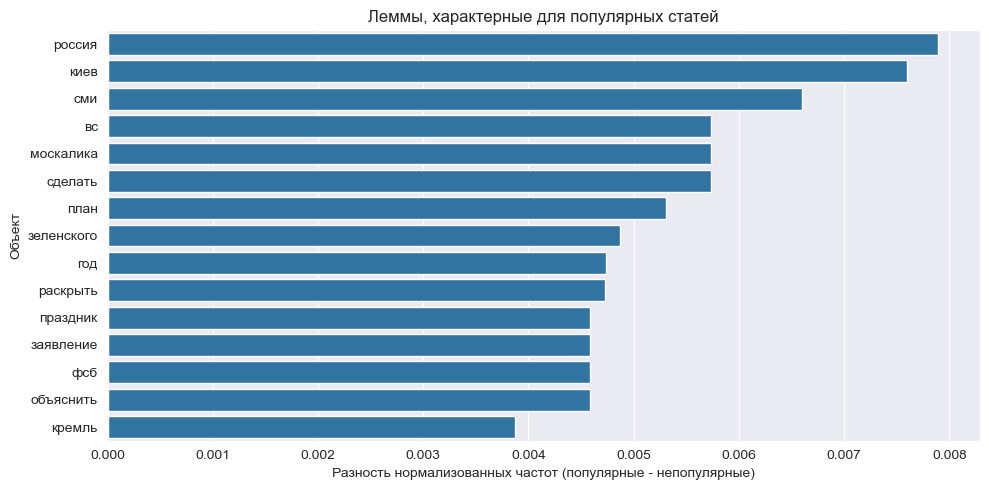


Характерные теги популярных статей:


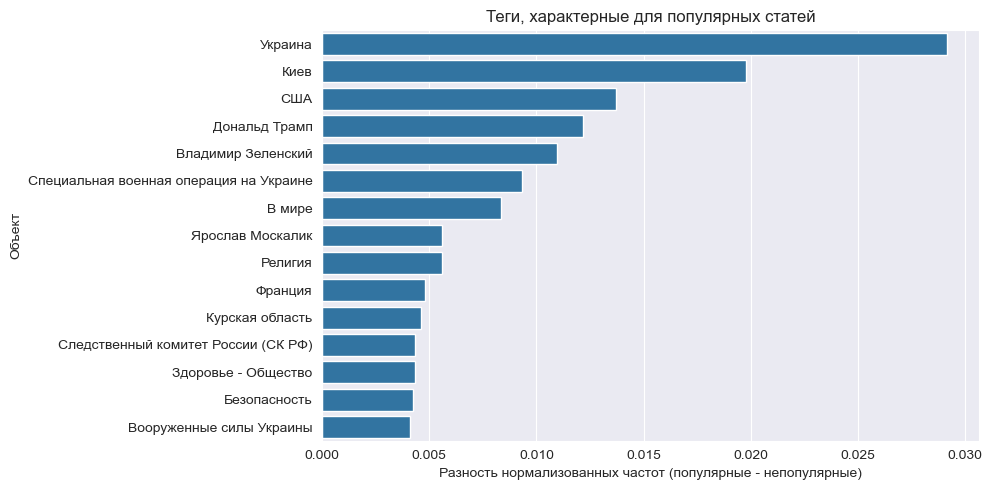


Характерные сущности популярных статей:


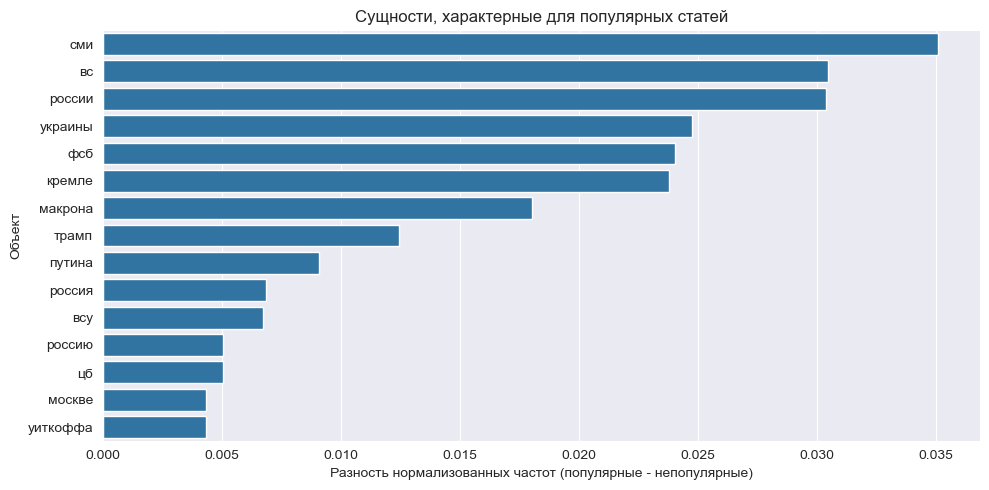

In [35]:
# Вывод результатов
print("\nХарактерные леммы популярных статей:")
top_differential_words(lemmas_pop, lemmas_non, "Леммы, характерные для популярных статей")

print("\nХарактерные теги популярных статей:")
top_differential_words(tags_pop, tags_non, "Теги, характерные для популярных статей")

print("\nХарактерные сущности популярных статей:")
top_differential_words(ents_pop, ents_non, "Сущности, характерные для популярных статей")


## 4. Простая модель: предсказание популярности статьи
Строим логистическую регрессию для предсказания популярности статьи на основе числовых признаков.
Также анализируем важность признаков по величине коэффициентов модели.


In [36]:
# Подготовка данных для модели
X = df[["num_tags", "num_words", "num_entities"]]
y = df["is_popular"]

In [42]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [43]:
# Обучение модели
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [47]:
# Оценка качества модели
y_pred = model.predict(X_test)
print("Классификационный отчёт модели LogisticRegression:")
print("Пояснение:")
print(" - precision: точность — доля правильных предсказаний среди всех предсказаний этого класса")
print(" - recall: полнота — доля найденных объектов данного класса среди всех объектов этого класса")
print(" - f1-score: гармоническое среднее между precision и recall")
print("Важно: модель плохо предсказывает популярные статьи (class 1), так как они встречаются редко. Это типичная проблема дисбаланса классов.")
print(classification_report(y_test, y_pred, zero_division=0))

Классификационный отчёт модели LogisticRegression:
Пояснение:
 - precision: точность — доля правильных предсказаний среди всех предсказаний этого класса
 - recall: полнота — доля найденных объектов данного класса среди всех объектов этого класса
 - f1-score: гармоническое среднее между precision и recall
Важно: модель плохо предсказывает популярные статьи (class 1), так как они встречаются редко. Это типичная проблема дисбаланса классов.
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       214
           1       0.13      0.54      0.20        24

    accuracy                           0.58       238
   macro avg       0.52      0.56      0.46       238
weighted avg       0.84      0.58      0.66       238



Коэффициенты модели (чем больше, тем выше вклад в предсказание популярности):
           Признак  Коэффициент
0      Число тегов     0.283873
1       Число слов    -0.054688
2  Число сущностей    -0.193851


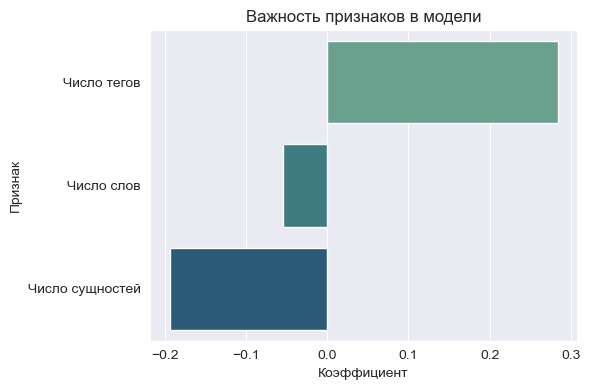

In [51]:
coef_df = pd.DataFrame({"Признак": ["Число тегов", "Число слов", "Число сущностей"], "Коэффициент": model.coef_[0]})
print("Коэффициенты модели (чем больше, тем выше вклад в предсказание популярности):")
print(coef_df)

plt.figure(figsize=(6, 4))
sns.barplot(data=coef_df, x="Коэффициент", y="Признак", hue="Признак", palette="crest", legend=False)
plt.title("Важность признаков в модели")
plt.tight_layout()
plt.show()